In [1]:
from docplex.mp.model import Model
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp
import matplotlib.pyplot as plt 
import networkx as nx

In [2]:
# General imports
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

# SciPy minimizer routine
from scipy.optimize import minimize

# rustworkx graph library
import rustworkx as rx
from rustworkx.visualization import mpl_draw

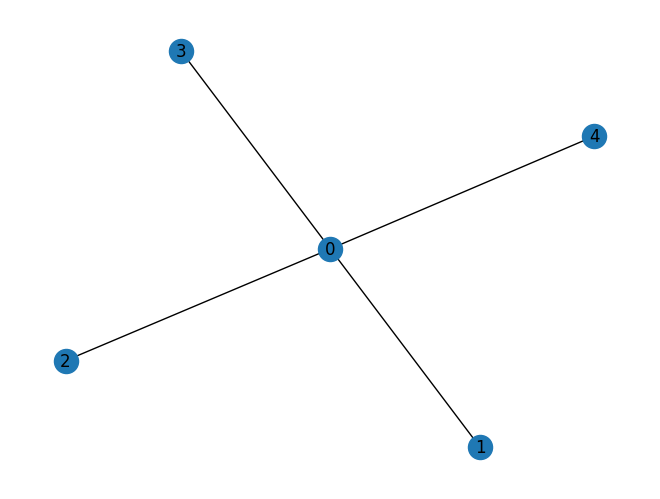

In [3]:
num_nodes = 5
# The edge syntax is (start, end, weight)
edges = [(0, 1), (0, 2), (0, 3), (0, 4)]

G = nx.Graph(edges)

nx.draw(G, with_labels=True)

En QISKIT il existe plusieurs moyen d'encoder un Hamiltonien, ceci est celle qui a mon avis me semble la plus intuitive pour vous. On utilise un module pour initier un QUBO et le transformer en String de Pauli, celle-ci sera utiliser pour notre Hamiltonien de cout.

In [4]:
# Parameters of the problem.
a = 1.0
b = 1.0
N = G.number_of_nodes()

In [5]:
mdl = Model()

# Here we define the binary variable so the X_i
x = {i: mdl.binary_var(name=f'x_{i}') for i in range(N)}

# For the sake of readability, we have subdivided H_a into three distinct equations, 
# with each equation mirroring the one previously explained, partitioned by the addition operator (+)
one = a * mdl.sum(x[i] for i in range(N))**2 
two = b * mdl.sum((1 - x[u]*x[j])/2 for u in range(N) for v in range(N) if v in G[u] for j in range(N))

# Here we combined the two equation to form the entire Hamiltonian.
objective = one + two

# We decided to minimize the problem.
mdl.minimize(objective)

# We transform the Hamiltonian euqation into a Qubo for Qiskit.
qp = from_docplex_mp(mdl)

# Finaly we create the ising model with the Qubo for Qiskit.
H, offset = QuadraticProgram.to_ising(qp)
print('Offset:', offset)
print('Ising Hamiltonian:')
print(H)

Offset: 21.5
Ising Hamiltonian:
SparsePauliOp(['IIIIZ', 'IIIZZ', 'IIIZI', 'IIZIZ', 'IIZII', 'IZIIZ', 'IZIII', 'ZIIIZ', 'ZIIII', 'IIZZI', 'IZIZI', 'ZIIZI', 'IZZII', 'ZIZII', 'ZZIII'],
              coeffs=[ 1.   +0.j, -0.125+0.j, -0.875+0.j, -0.125+0.j, -0.875+0.j, -0.125+0.j,
 -0.875+0.j, -0.125+0.j, -0.875+0.j,  0.25 +0.j,  0.25 +0.j,  0.25 +0.j,
  0.25 +0.j,  0.25 +0.j,  0.25 +0.j])


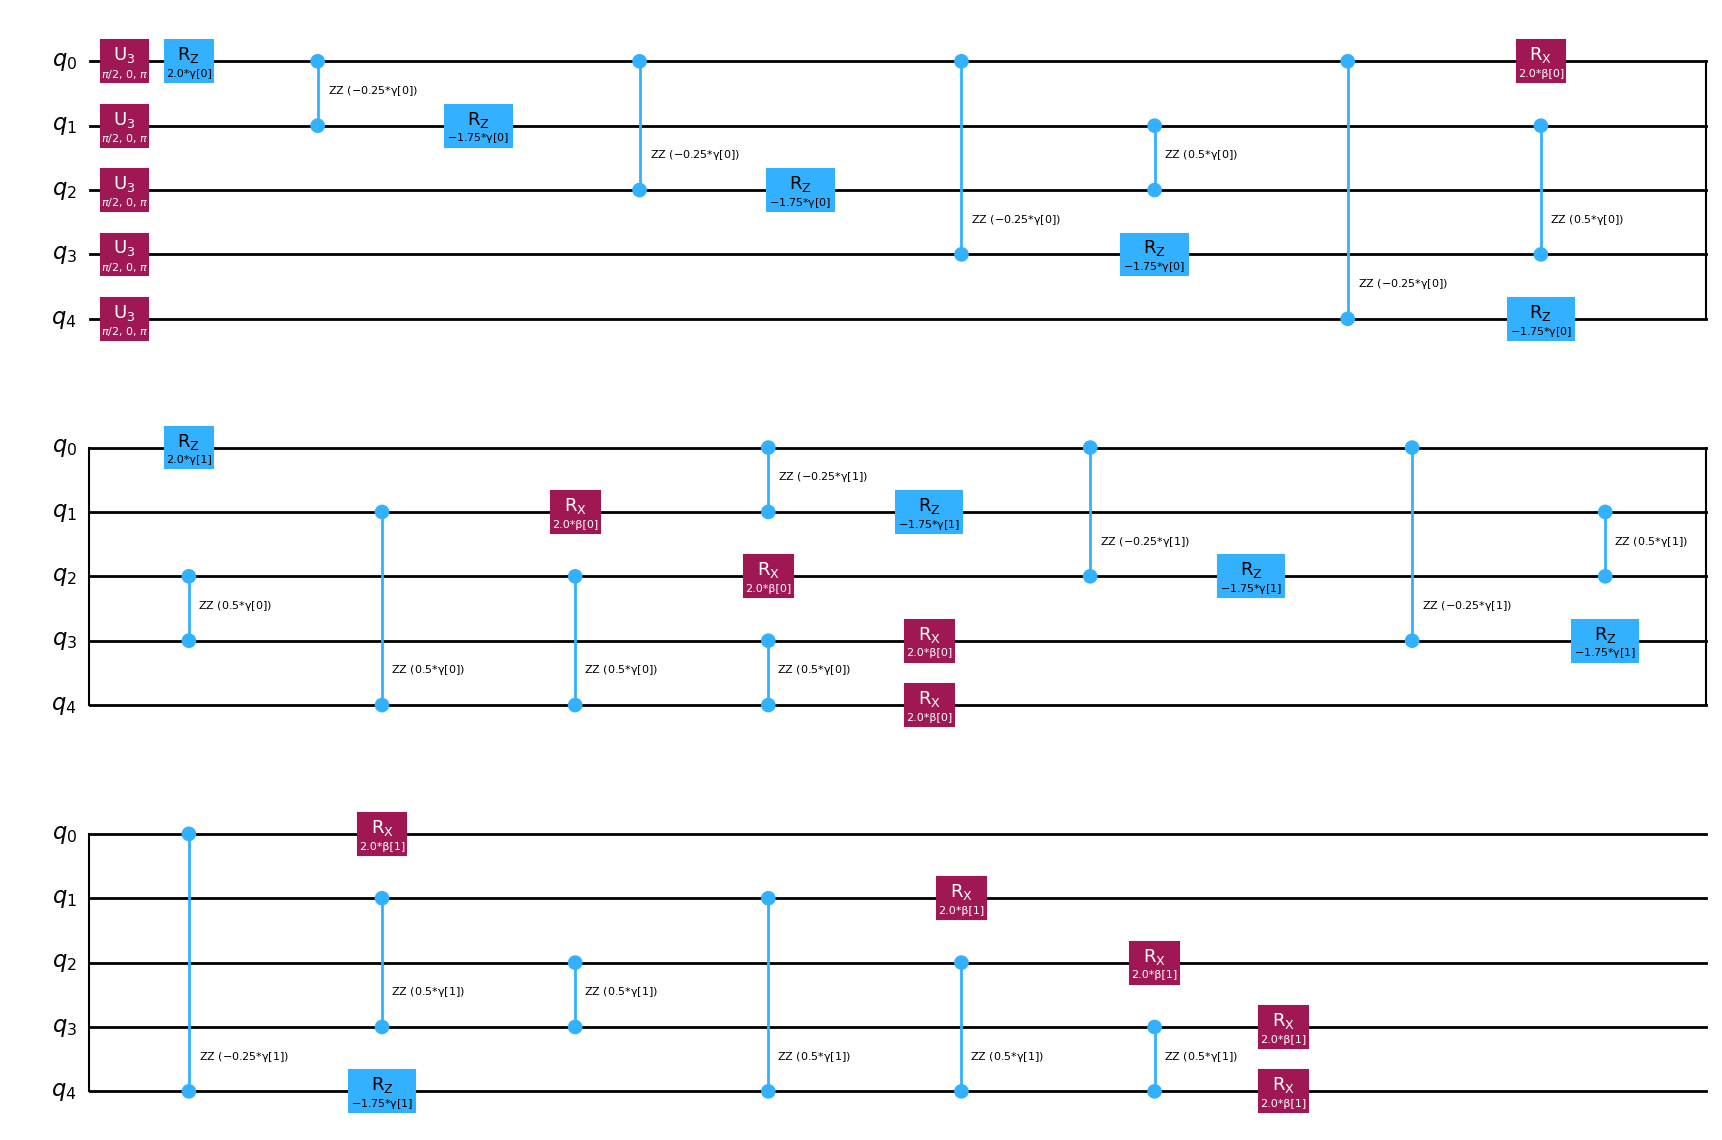

In [6]:
# Problem to Hamiltonian operator
# hamiltonian = SparsePauliOp.from_list([("IIIZZ", 1), ("IIZIZ", 1), ("IZIIZ", 1), ("ZIIIZ", 1)])
hamiltonian = H
# QAOA ansatz circuit
ansatz = QAOAAnsatz(hamiltonian, reps=2)

ansatz.decompose(reps=3).draw(output="mpl", style="iqp")

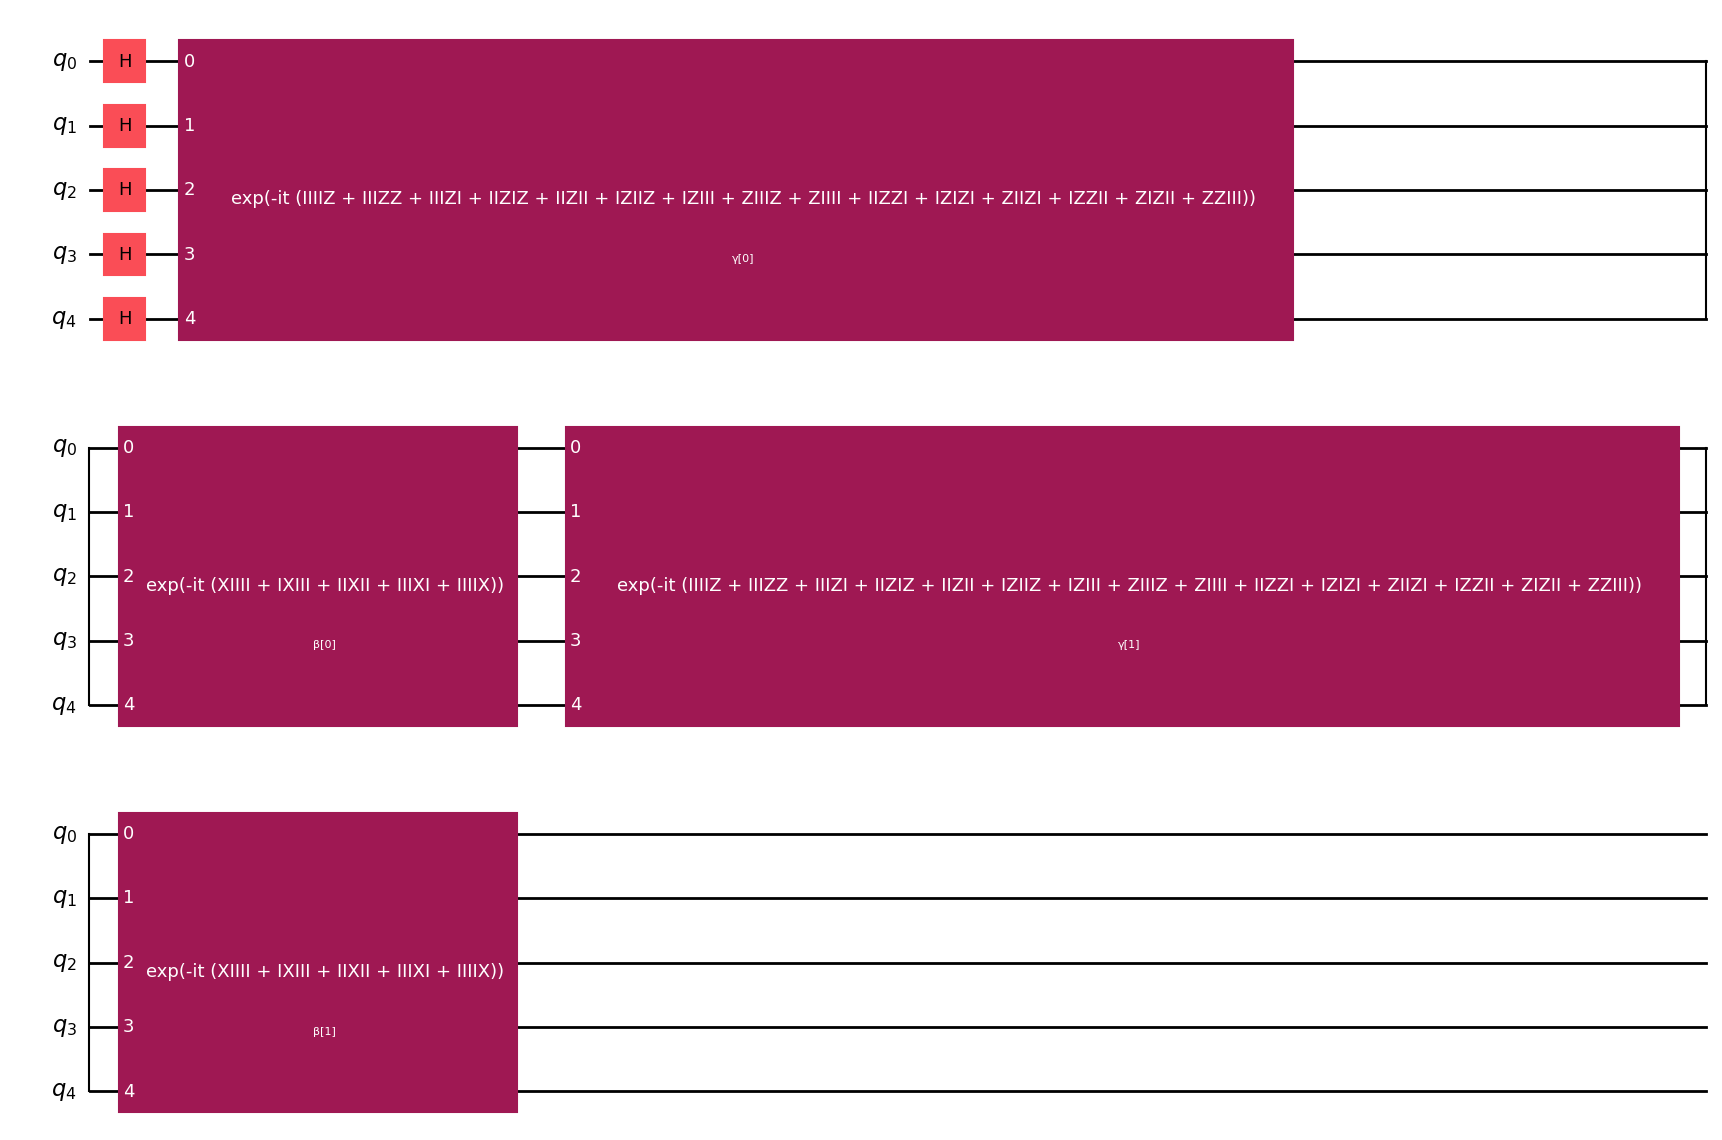

In [7]:
ansatz.decompose().draw(output="mpl", style="iqp")

In [10]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level=1)

ansatz_isa = pm.run(ansatz)

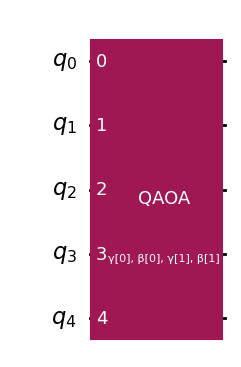

In [11]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [12]:
hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)
hamiltonian_isa

SparsePauliOp(['IIIIZ', 'IIIZZ', 'IIIZI', 'IIZIZ', 'IIZII', 'IZIIZ', 'IZIII', 'ZIIIZ', 'ZIIII', 'IIZZI', 'IZIZI', 'ZIIZI', 'IZZII', 'ZIZII', 'ZZIII'],
              coeffs=[ 1.   +0.j, -0.125+0.j, -0.875+0.j, -0.125+0.j, -0.875+0.j, -0.125+0.j,
 -0.875+0.j, -0.125+0.j, -0.875+0.j,  0.25 +0.j,  0.25 +0.j,  0.25 +0.j,
  0.25 +0.j,  0.25 +0.j,  0.25 +0.j])

In [13]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    cost = result[0].data.evs[0]

    return cost

In [15]:
from qiskit.primitives import StatevectorEstimator,StatevectorSampler

# Configure estimator
estimator = StatevectorEstimator()


# Configure sampler
sampler = StatevectorSampler()


In [16]:
x0 = 2 * np.pi * np.random.rand(ansatz_isa.num_parameters)

In [23]:
res = minimize(cost_func, x0, args=(ansatz_isa, hamiltonian_isa, estimator), method="COBYLA")

In [24]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.2842010601447624
       x: [ 2.819e+00  5.461e-01  5.597e+00  2.160e+00]
    nfev: 151
   maxcv: 0.0

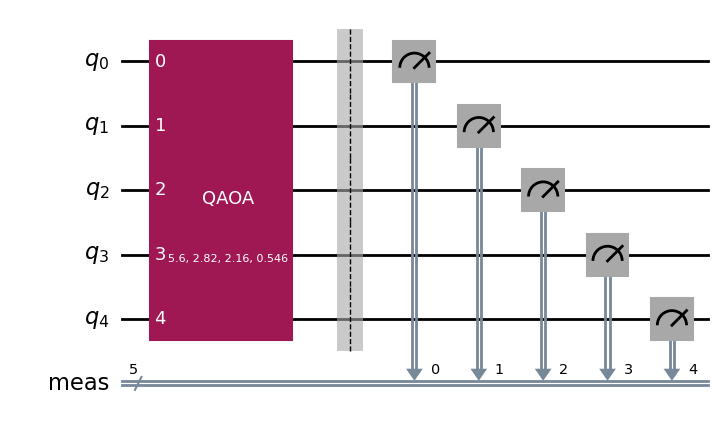

In [25]:
# Assign solution parameters to ansatz
qc = ansatz.assign_parameters(res.x)
# Add measurements to our circuit
qc.measure_all()
qc_isa = pm.run(qc)
qc_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [26]:
result = sampler.run([qc_isa]).result()
samp_dist = result[0].data.meas.get_counts()

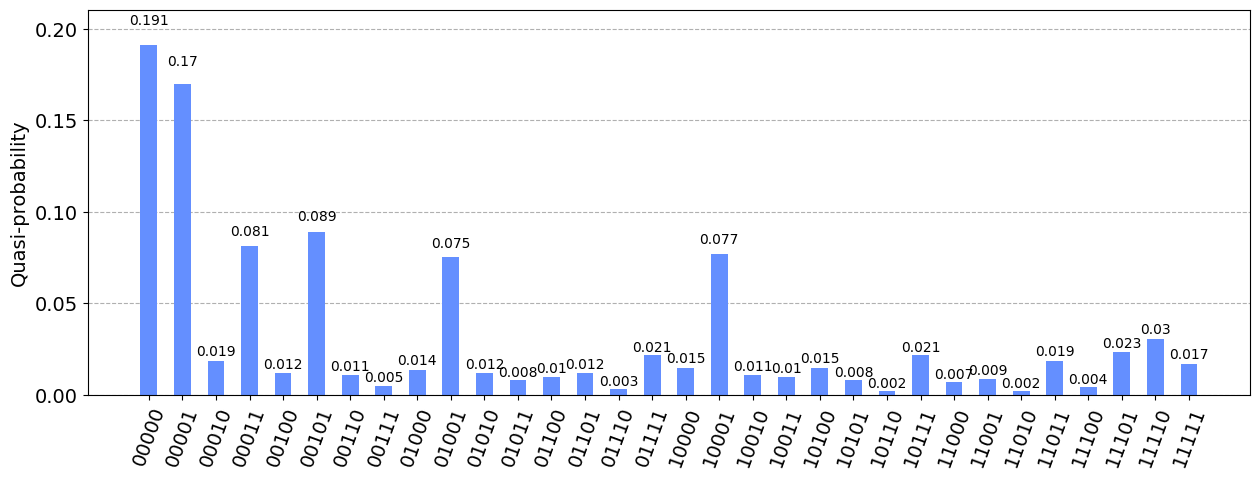

In [27]:
plot_distribution(samp_dist, figsize=(15, 5))

In [58]:
from docplex.mp.model import Model
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp

In [ ]:
# Parameters of the problem.
a = 1.0
b = 1.0
N = G.number_of_nodes()
mdl = Model()

# Here we define the binary variable so the X_i
x = {i: mdl.binary_var(name=f'x_{i}') for i in range(N)}

# For the sake of readability, we have subdivided H_a into three distinct equations, 
# with each equation mirroring the one previously explained, partitioned by the addition operator (+)
one = a* mdl.sum((1 - x[u])*(1 - x[v]) for u in range(N) for v in range(N) if v in G[u])

two = b * mdl.sum(x[v] for v in range(N))

# Here we combined the two equation to form the entire Hamiltonian.
objective = one + two

# We decided to minimize the problem.
mdl.minimize(objective)

# We transform the Hamiltonian euqation into a Qubo for Qiskit.
qp = from_docplex_mp(mdl)

# Finaly we create the ising model with the Qubo for Qiskit.
H, offset = QuadraticProgram.to_ising(qp)
print('Offset:', offset)
print('Ising Hamiltonian:')
print(H)

# À vous de jouer encoder l'Hamiltonien suivant qui est le problème de Vertex Cover sur le graphique suivant:

Here we define ours parameters to build our Hamiltonian. The formula for the Hamiltonian that we want to build is : 

$$
H_A = A\sum_{(u,v) \in E}(1-x_u)(1-x_v)
$$

$$
H_B = B\sum_{v}x_v
$$

$$ H = H_A + H_B $$

$$ x \text{ is a binary variable}, \quad v \text{ is the vertex} $$

In the subsequent section, we establish the values for A, B, and N. Specifically, N is defined as $N = |V|$, where $V$ represents the set of vertices in the graph $G = (V, E)$.

We also define the optimizer that we will use to execute QAOA or VQE.

L'équation est pris de : https://www.frontiersin.org/articles/10.3389/fphy.2014.00005/full

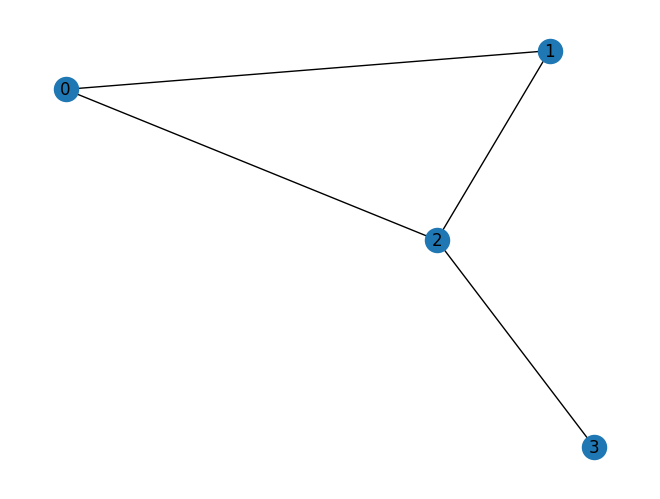

In [59]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3)]
G = nx.Graph(edges)

nx.draw(G, with_labels=True)

In [28]:
# Parameters of the problem.
a = 1.0
b = 1.0
N = G.number_of_nodes()

Implementer le code pour le problème d'Ising et le code de QAOA. Le code plus haut est pris en partie de l'exemple : https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm

In [29]:
mdl = Model()

# Here we define the binary variable so the X_i
x = {i: mdl.binary_var(name=f'x_{i}') for i in range(N)}

# For the sake of readability, we have subdivided H_a into three distinct equations, 
# with each equation mirroring the one previously explained, partitioned by the addition operator (+)

####################
# À completer
####################

objective = 

# We decided to minimize the problem.
mdl.minimize(objective)

# We transform the Hamiltonian euqation into a Qubo for Qiskit.
qp = from_docplex_mp(mdl)

# Finaly we create the ising model with the Qubo for Qiskit.
H, offset = QuadraticProgram.to_ising(qp)
print('Offset:', offset)
print('Ising Hamiltonian:')
print(H)

SyntaxError: invalid syntax (4130739922.py, line 12)

I